In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.applications import VGG16
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

In [ ]:
train_data_dir = '/content/drive/MyDrive/FinalProject/archive/Garbage classification/Garbage classification'
img_width = 224
img_height = 224
batch_size = 32

# Augmentation data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,        
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    validation_split=0.1
    )
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Use flow_from_directory to train on batch, class_mode = categorical because have 6 classes
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=19
    ) 

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed=19
    )


Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [ ]:
# We use model VGG16
pre_train_model = VGG16(
      include_top = False,
      weights = "imagenet",
      pooling='avg',
      input_shape = (img_width, img_height, 3)      
)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
pre_train_model.trainable = False
last_output = pre_train_model.output

In [ ]:
from keras.layers import Dense, BatchNormalization, Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import PReLU, LeakyReLU

In [ ]:
x = Flatten()(last_output)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

In [ ]:
# Define optimizer, learning rate and loss function
model = Model(pre_train_model.input, output)
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
myCallbacks = [
    keras.callbacks.EarlyStopping(monitor='val_acc',patience=25),
    keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/FinalProject/VGG16/logs/vgg/VGG16_{epoch:02d}_{val_acc:.2f}.h5',
                                    monitor='val_acc',mode='max',save_best_only=True, save_freq='epoch')    
]

In [ ]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_validation = validation_generator.n//validation_generator.batch_size

history = model.fit(
      train_generator,
      steps_per_epoch = step_size_train,
      epochs = 60, #change it
      shuffle=False,
      verbose = 1,
      validation_data = validation_generator,
      validation_steps = step_size_validation,
      callbacks= myCallbacks
      )

Epoch 1/60
71/71 [==============================] - 445s 6s/step - loss: 1.4416 - acc: 0.4732 - val_loss: 0.7751 - val_acc: 0.7455
Epoch 2/60
71/71 [==============================] - 85s 1s/step - loss: 0.8351 - acc: 0.6976 - val_loss: 0.6504 - val_acc: 0.7366
Epoch 3/60
71/71 [==============================] - 84s 1s/step - loss: 0.7035 - acc: 0.7500 - val_loss: 0.5647 - val_acc: 0.7812
Epoch 4/60
71/71 [==============================] - 84s 1s/step - loss: 0.6300 - acc: 0.7610 - val_loss: 0.4666 - val_acc: 0.8214
Epoch 5/60
71/71 [==============================] - 83s 1s/step - loss: 0.6068 - acc: 0.7821 - val_loss: 0.4786 - val_acc: 0.8259
Epoch 6/60
71/71 [==============================] - 84s 1s/step - loss: 0.5516 - acc: 0.7984 - val_loss: 0.4274 - val_acc: 0.8214
Epoch 7/60
71/71 [==============================] - 85s 1s/step - loss: 0.5503 - acc: 0.8077 - val_loss: 0.4215 - val_acc: 0.8438
Epoch 8/60
71/71 [==============================] - 85s 1s/step - loss: 0.5301 - acc: 0.8

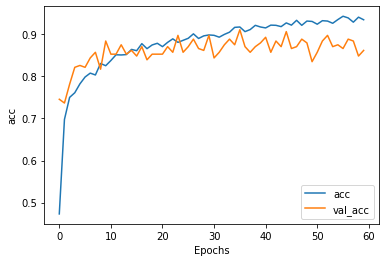

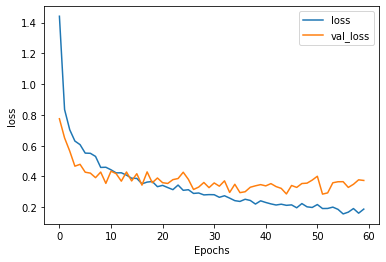

In [ ]:
#Visualize Training
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'acc')
plot_graphs(history,'loss')

In [ ]:
#test model
loss= model.evaluate(validation_generator, steps=validation_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

251/251 [==============================] - 9s 29ms/step - loss: 0.3926 - acc: 0.8486
loss test: 0.39
accuracy test: 0.85


In [ ]:
class_labels = list(validation_generator.class_indices.keys()) 
class_labels

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

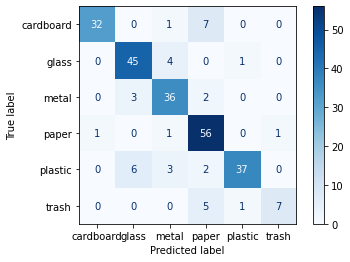

In [ ]:
from sklearn import metrics
#Confution Matrix
Y_pred = model.predict(validation_generator, step_size_validation // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = metrics.confusion_matrix(validation_generator.classes, y_pred)

class_labels = list(validation_generator.class_indices.keys()) 
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
results = model.predict(validation_generator, steps=validation_generator.n)
predicted_classes = np.argmax(results, axis=1)
# print(predicted_classes)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

   cardboard       1.00      0.80      0.89        40
       glass       0.78      0.94      0.85        50
       metal       0.83      0.85      0.84        41
       paper       0.80      0.97      0.88        59
     plastic       0.87      0.71      0.78        48
       trash       1.00      0.54      0.70        13

    accuracy                           0.84       251
   macro avg       0.88      0.80      0.82       251
weighted avg       0.86      0.84      0.84       251



In [ ]:
from matplotlib.pyplot import imshow
from PIL import Image

image_path="/content/drive/MyDrive/data/validation/paper/paper164.jpg"
im = Image.open(image_path).resize((224,224))
imshow(np.asarray(im))
#im = im.convert('RGB')
im = np.array(im)
im = im.reshape(-1,224,224,3)
im = 2*(im/255.0)-1.0
result = model.predict(im)  
predicted_class_indices=np.argmax(result,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print("Predicted class: ",predictions[0])

FileNotFoundError: ignored